# TM10007 Assignment template

In [2]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data

# Import classifiers
from sklearn import model_selection

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

X = data.drop("label",axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)


The number of samples: 115
The number of columns: 494


### Preprocessing

Missing data
* Part 1: Finding missing data

In [26]:
# Define missing value indicators
custom_missing = ['NA', 'null', 'N/A', '?', 'None', 'none', '-']

# Count NaNs
nan_counts = X_train.isna().sum()
nan_counts_selected = nan_counts[nan_counts !=0]

# Count empty strings
empty_string_counts = (X_train == '').sum()
empty_string_counts_selected = empty_string_counts[empty_string_counts != 0]

# Count zero's
zero_counts = (X_train == 0).sum()
zero_counts_selected = zero_counts[zero_counts != 0]

# Count custom missing indicators (case-insensitive match)
custom_missing_counts = X_train.apply(lambda col: col.astype(str).str.lower().isin([val.lower() for val in custom_missing]).sum())
custom_missing_counts_selected = custom_missing_counts[custom_missing_counts !=0]

# Printing
print(nan_counts_selected)
print(empty_string_counts_selected)
print(zero_counts_selected)
print(custom_missing_counts_selected)
#X_train_zero_columns = X_train[zero_counts_selected.index]
#X_train_zero_columns

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


* Part 2: Processing missing data

In [27]:
# Missing data was only find in the form of zero's, therefore only zero_counts is further used.
limit = len(X_train.index)*50/100 #If 50% or more of the data within one feature is missing the feature is deleted
valid_columns = [col for col, count in zero_counts.items() if count < limit]

# Keep only the valid columns in both X_train and X_test
X_train = X_train[valid_columns]
X_test = X_test[valid_columns]

# Imputate remaining zero's
# Import
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro

# Replace zeros with NaN
X_train.replace(0, np.nan, inplace=True)
X_test.replace(0, np.nan, inplace=True)

imputation_strategies = {}  # Store mean/median decision per column

for col in X_train.select_dtypes(include=['number']).columns:  # Only numeric columns
    col_data = X_train[col].dropna()  # Remove NaN values for testing

    if len(col_data) > 3:  # Shapiro requires at least 3 non-null values
        if col_data.nunique() == 1:  # Check if all values are the same
            strategy = 'median'  # Default to median if no variability
        else:
            _, p = shapiro(col_data)
            strategy = 'mean' if p > 0.05 else 'median'
    else:
        strategy = 'median'  # Default to median if too few values

    imputation_strategies[col] = strategy

# Create imputers for mean and median
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')

for col, strategy in imputation_strategies.items():
    imputer = mean_imputer if strategy == 'mean' else median_imputer
    X_train[[col]] = imputer.fit_transform(X_train[[col]])
    X_test[[col]] = imputer.transform(X_test[[col]])  # Use the same imputer

Scaling data

In [28]:
import pandas as pd
from sklearn import preprocessing

scaler_MaxAbsScaler = preprocessing.MaxAbsScaler()
scaler_Normalizer = preprocessing.Normalizer()
scaler_standard = preprocessing.StandardScaler()
scaler_minmax = preprocessing.MinMaxScaler()
scaler_robust = preprocessing.RobustScaler()

scaled_MaxAbsScaler_array_train = scaler_MaxAbsScaler.fit_transform(X_train)
scaled_MaxAbsScaler_array_test = scaler_MaxAbsScaler.transform(X_test)
scaled_Normalizer_array_train = scaler_Normalizer.fit_transform(X_train)
scaled_Normalizer_array_test = scaler_Normalizer.transform(X_test)
scaled_standard_array_train = scaler_standard.fit_transform(X_train)
scaled_standard_array_test = scaler_standard.transform(X_test)
scaled_minmax_array_train = scaler_minmax.fit_transform(X_train)
scaled_minmax_array_test = scaler_minmax.transform(X_test)
scaled_robust_array_train = scaler_robust.fit_transform(X_train)
scaled_robust_array_test = scaler_robust.transform(X_test)

X_scaled_MaxAbsScaler_train = pd.DataFrame(scaled_MaxAbsScaler_array_train, columns=X_train.columns)
X_df_scaled_Normalizer_train = pd.DataFrame(scaled_Normalizer_array_train, columns=X_train.columns)
X_scaled_Normalizer_test = pd.DataFrame(scaled_Normalizer_array_test, columns=X_test.columns)
X_scaled_standard_train = pd.DataFrame(scaled_standard_array_train, columns=X_train.columns)
X_scaled_standard_test = pd.DataFrame(scaled_standard_array_test, columns=X_test.columns)
X_scaled_minmax_train = pd.DataFrame(scaled_minmax_array_train, columns=X_train.columns)
X_scaled_minmax_test = pd.DataFrame(scaled_minmax_array_test, columns=X_test.columns)
X_scaled_robust_train = pd.DataFrame(scaled_robust_array_train, columns=X_train.columns)
X_scaled_robust_test = pd.DataFrame(scaled_robust_array_test, columns=X_test.columns)


Feature extraction

Lloyd

Inge: Optimization based feature selection > Lasso 

Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
Best alpha found: 0.05689866029018299
Selected Features: Index(['PREDICT_original_sf_compactness_avg_2.5D',
       'PREDICT_original_sf_volume_2.5D', 'PREDICT_original_of_theta_x',
       'PREDICT_original_hf_skewness', 'PREDICT_original_logf_peak_sigma10',
       'PREDICT_original_tf_GLCMMS_contrastd3.0A2.36std',
       'PREDICT_original_tf_GLCMMS_dissimilarityd3.0A2.36std',
       'PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.79mean',
       'PREDICT_original_tf_GLCMMS_ASMd3.0A1.57std',
       'PREDICT_original_tf_Gabor_min_F0.05_A0.0',
       'PREDICT_original_tf_Gabor_skewness_F0.05_A0.0',
       'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.0',
       'PREDICT_original_tf_Gabor_mean_F0.2_A0.79',
       'PREDICT_original_tf_Gabor_peak_F0.2_A0.79',
       'PREDICT_original_tf_Gabor_median_F0.2_A1.57',
       'PREDICT_original_tf_Gabor_median_F0.5_A0.0',
       'PREDICT_original_tf_Gabor_median_F0.5_A2.36',
       'PREDICT_original_v

/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


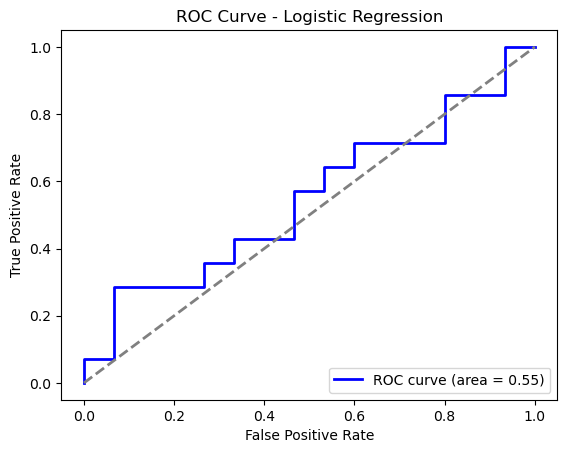

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

# Encode y labels to numeric values
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)
y_test_numeric = le.transform(y_test)

# Store the mapping of labels
legend_labels = le.classes_  # This saves the original class names
print("Label Mapping:", {i: label for i, label in enumerate(legend_labels)})

# Define LassoCV with cross-validation
alphas=np.logspace(-4, 1, 50) # Testing alpha from 0.0001 to 10
random_state = 42 #  Using int will produce the same results everytime, 42 is along 0 the most popular choice
lasso_cv = LassoCV(cv=5, alphas=alphas, random_state=random_state, max_iter=10000)  # cv = 5 chosen 

# Fit LassoCV on training data
lasso_cv.fit(X_scaled_standard_train, y_train_numeric)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

# Train final Lasso model with optimal alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_scaled_standard_train, y_train_numeric)

# Select features
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_scaled_standard_train)
X_test_selected = selector.transform(X_scaled_standard_test)

# Get selected feature indices and names
selected_features = np.where(selector.get_support())[0]
selected_feature_names = X_scaled_standard_train.columns[selected_features]
print("Selected Features:", selected_feature_names)

## Logistic Regression CLF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train the logistic regression model with selected features
clf = LogisticRegression(random_state=random_state)
clf.fit(X_train_selected, y_train_numeric)

# Make predictions on the test set
y_pred = clf.predict(X_test_selected)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test_numeric, y_pred))
print("Classification Report:\n", classification_report(y_test_numeric, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_numeric, y_pred))

## Random Forest CLF
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Random Forest
rf_clf = RandomForestClassifier(random_state=random_state)
rf_clf.fit(X_train_selected, y_train_numeric)

# SVM
svm_clf = SVC(random_state=random_state)
svm_clf.fit(X_train_selected, y_train_numeric)

# Predictions for Random Forest and SVM
rf_y_pred = rf_clf.predict(X_test_selected)
svm_y_pred = svm_clf.predict(X_test_selected)

# Evaluate the models
print("Random Forest Accuracy:", accuracy_score(y_test_numeric, rf_y_pred))
print("SVM Accuracy:", accuracy_score(y_test_numeric, svm_y_pred))

## ROC Curve and AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curve for Logistic Regression, Random Forest, and SVM
fpr, tpr, _ = roc_curve(y_test_numeric, clf.predict_proba(X_test_selected)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


Random forest